In [1]:
import numpy as np
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
########### splitting data ############
import splitfolders
splitfolders.ratio('/kaggle/input/audataset/AugmentedAlzheimerDataset', output="Inputs", seed=1345, ratio=(0.7,0.3,0))# seed was 1345
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

Copying files: 33984 files [02:28, 228.57 files/s]


In [3]:
############################# load and read DataSet #########################################
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess the dataset (Assuming dataset path is available)
#dataset_dir = 'path_to_AD_dataset'
data_dir = '/kaggle/working/Inputs'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

#hho = HarrisHawkOptimizer(N=train_generator.samples, Acc=0.97)
#optimized_params = hho.optimize()

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    #dataset_dir,
    train_dir,
    target_size=(128, 128),
    #batch_size=best_params[1],  # Optimized batch size
    batch_size=8,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    #dataset_dir,
    test_dir,
    target_size=(128,128),
    #batch_size=best_params[1],
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

Found 19032 images belonging to 4 classes.
Found 2037 images belonging to 4 classes.


In [4]:
############################################# build the Model ResNet152V2####################
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2  ### regulaizer

dropout_factor = 0.7
epochs=350

# Load ResNet152V2 base model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(128,128, 3))

for layers in base_model.layers[:100]:
        layers.trainable = False
for layers in base_model.layers[100:]:
        layers.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(dropout_factor)(x)  # Optimized dropout factor
x = Dense(1024, activation='relu')(x)
x = Dropout(dropout_factor)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(dropout_factor)(x)  
#output layer
output = Dense(4, activation='softmax')(x)#,kernel_regularizer=l2(0.01))(x)#### here  l2

model = Model(inputs=base_model.input, outputs=output)
# Set the initial learning rate
initial_lr = 0.01  # You can adjust this value based on your needs

# Define the optimizer
optimizers = SGD(learning_rate=initial_lr)


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])


# Define callbacks: EarlyStopping, ReduceLROnPlateau, 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,min_lr=1e-6)# learning rate
#checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)





234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,  # Optimized epoch number
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    batch_size=8,
    verbose=1)


Epoch 1/350


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731681244.739161     114 service.cc:145] XLA service 0x7ccaac004dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731681244.739238     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731681244.739243     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731681292.384729     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2379/2379 ━━━━━━━━━━━━━━━━━━━━ 354s 108ms/step - accuracy: 0.2864 - loss: 1.6001 - val_accuracy: 0.4212 - val_loss: 1.0315 - learning_rate: 0.0100
Epoch 2/350
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step - accuracy: 0.4242 - loss: 1.0883 - val_accuracy: 0.5101 - val_loss: 0.9049 - learning_rate: 0.0100
Epoch 3/350
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step - accuracy: 0.4995 - loss: 0.9338 - val_accuracy: 0.6343 - val_loss: 0.7929 - learning_rate: 0.0100
Epoch 4/350
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step - accuracy: 0.5665 - loss: 0.9088 - val_accuracy: 0.6505 - val_loss: 0.7463 - learning_rate: 0.0100
Epoch 5/350
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step - accuracy: 0.6620 - loss: 0.7302 - val_accuracy: 0.7614 - val_loss: 0.5381 - learning_rate: 0.0100
Epoch 6/350
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step - accuracy: 0.7399 - loss: 0.5728 - val_accuracy: 0.7212 - val_loss: 0.6029 - learning_rate: 0.0100
Epoch 7/350
2379/2379 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step

In [6]:
########################################### Compute perfromance Metrics##############
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Plot accuracy and loss curves
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.show()

# ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names):
    fpr, tpr, roc_auc = {}, {}, {}
    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
        
    for class_name in class_names:
        plt.plot(fpr[class_name], tpr[class_name], label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()

# Use class names for Alzheimer's disease stages
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']



255/255 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step


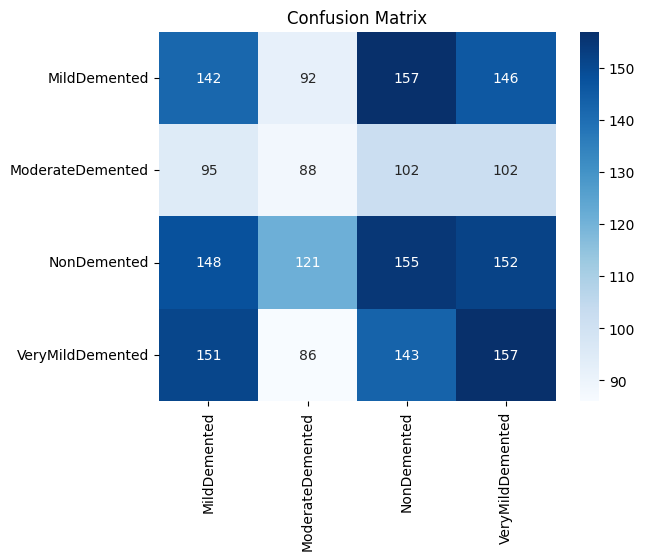

In [7]:
# After training, get predictions
y_pred = model.predict(validation_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = validation_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels, class_names)


255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step


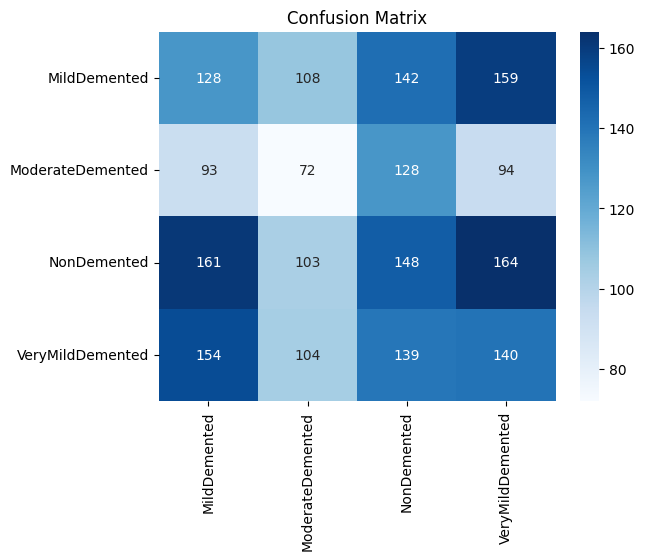

                  precision    recall  f1-score   support

    MildDemented       0.24      0.24      0.24       537
ModerateDemented       0.19      0.19      0.19       387
     NonDemented       0.27      0.26      0.26       576
VeryMildDemented       0.25      0.26      0.26       537

        accuracy                           0.24      2037
       macro avg       0.24      0.24      0.24      2037
    weighted avg       0.24      0.24      0.24      2037



In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

# After training, get predictions
y_pred = model.predict(validation_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = validation_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
#fpr, tpr, _ = roc_curve(y_true_labels, y_pred)
#roc_auc = auc(fpr, tpr)
#plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.legend()
#plt.title('ROC Curve')
#plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=train_generator.class_indices.keys()))

In [9]:
# Plot ROC curve
#plot_roc_curve(validation_generator.labels, y_pred, class_names)

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


                  precision    recall  f1-score   support

    MildDemented       0.24      0.24      0.24       537
ModerateDemented       0.19      0.19      0.19       387
     NonDemented       0.27      0.26      0.26       576
VeryMildDemented       0.25      0.26      0.26       537

        accuracy                           0.24      2037
       macro avg       0.24      0.24      0.24      2037
    weighted avg       0.24      0.24      0.24      2037



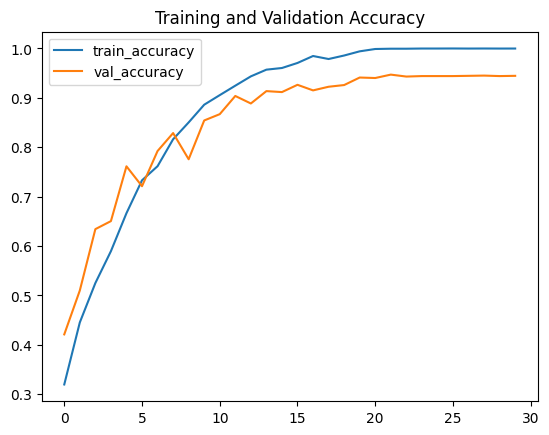

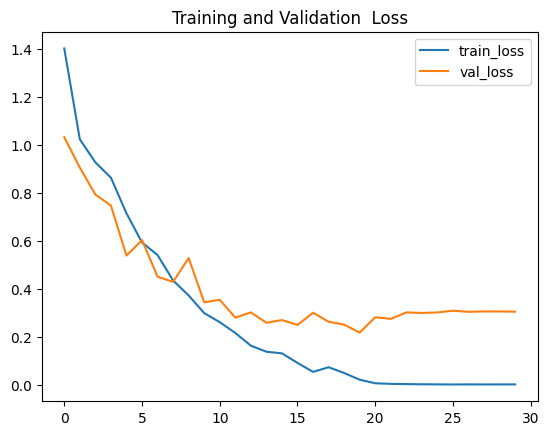

In [10]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation  Loss')
plt.show()

In [14]:
valid_loss, valid_accuracy = model.evaluate(train_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

2379/2379 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9995 - loss: 0.0025

Train loss: 0.00
Train Accuracy: 99.95 %


In [12]:
loss, accuracy = model.evaluate(validation_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

255/255 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9365 - loss: 0.2220

Test loss: 0.22 
Test Accuracy: 94.11 %


255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
Confusion Matrix:
[[132 110 139 156]
 [102  68 111 106]
 [147 112 166 151]
 [155  97 141 144]]


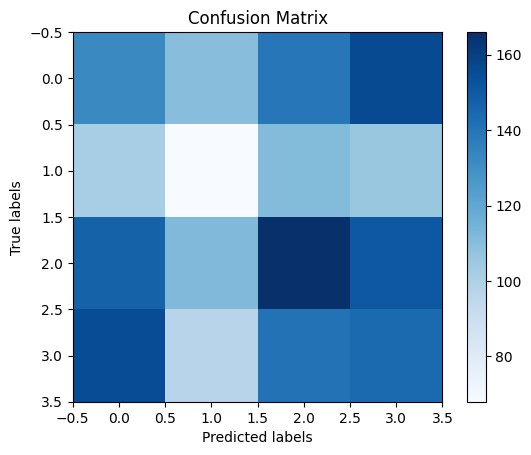

In [13]:
from sklearn.metrics import confusion_matrix
# Set the number of classes for your task
num_classes = 4

# Generate predictions on the test dataset
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
